In [2]:
import boto3
import urllib.request
from botocore.exceptions import ClientError

def fetch_raw_trip_data(year: int, month: int, bucket_name: str, s3_key_prefix: str) -> str:
    """
    Fetch raw trip data for a given year and month, and upload it to an S3 bucket
    only if the file does not already exist.

    Args:
        year (int): The year of the trip data.
        month (int): The month of the trip data.
        bucket_name (str): The name of the S3 bucket.
        s3_key_prefix (str): The prefix (folder path) in the S3 bucket.

    Returns:
        str: The S3 key (path) where the file was uploaded or a message indicating it already exists.

    Raises:
        Exception: If the file cannot be downloaded or uploaded.
    """
    # Construct the URL for the trip data
    URL = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"

    # Define the S3 key (path in the bucket)
    s3_key = f"{s3_key_prefix}/year={year}/month={month:02}/yellow_tripdata_{year}-{month:02}.parquet"

    # Initialize the S3 client
    s3_client = boto3.client('s3')

    # Check if the file already exists in the S3 bucket
    try:
        s3_client.head_object(Bucket=bucket_name, Key=s3_key)
        print(f"File already exists in S3: s3://{bucket_name}/{s3_key}")
        return f"File already exists in S3: s3://{bucket_name}/{s3_key}"
    except ClientError as e:
        # If the error is not a 404 (Not Found), re-raise it
        if e.response['Error']['Code'] != "404":
            raise Exception(f"Error checking file existence in S3: {e}")

    # Fetch the data from the URL
    print(f"Fetching raw data ...")
    try:
        with urllib.request.urlopen(URL) as response:
            if response.status == 200:
                print(f"Done fetching raw data ...")
                # File content
                file_content = response.read()

                try:
                    # Upload the file to S3
                    s3_client.put_object(Bucket=bucket_name, Key=s3_key, Body=file_content)
                    print(f"File uploaded to S3: s3://{bucket_name}/{s3_key}")
                    return f"File uploaded to S3: s3://{bucket_name}/{s3_key}"
                except ClientError as e:
                    raise Exception(f"Failed to upload file to S3: {e}")
            else:
                raise Exception(f"{URL} returned status code {response.status}")
    except Exception as e:
        raise Exception(f"Failed to fetch data from {URL}: {e}")


# Example usage
bucket_name = "mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990"
s3_key_prefix = "taxi/raw"
fetch_raw_trip_data(2023, 5, bucket_name, s3_key_prefix)

Fetching raw data ...
Done fetching raw data ...
File uploaded to S3: s3://mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990/taxi/raw/year=2023/month=05/yellow_tripdata_2023-05.parquet


'File uploaded to S3: s3://mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990/taxi/raw/year=2023/month=05/yellow_tripdata_2023-05.parquet'

In [112]:
from pathlib import Path
import pandas as pd
import requests

def fetch_raw_data(year: int, month: int) -> str:
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"
    response = requests.get(url)
    if response.status_code == 200:
        # Use pathlib to construct the path
        path = Path("..") / "data" / "raw" / f"rides_{year}_{month:02}.parquet"
        # Ensure the parent directory exists
        path.parent.mkdir(parents=True, exist_ok=True)
        # Write the content to the file
        path.write_bytes(response.content)
        print(f"Successfully fetched: {str(path)}")
        return str(path)
    else:
        raise Exception(f"{url} is not available")


fetch_raw_data(2022, 12)

Successfully fetched: ../data/raw/rides_2022_12.parquet


'../data/raw/rides_2022_12.parquet'

In [113]:
fetch_raw_data(2023, 3)


Successfully fetched: ../data/raw/rides_2023_03.parquet


'../data/raw/rides_2023_03.parquet'

In [114]:
import pandas as pd
from pathlib import Path

def load_data(year, month):
    file_path = path = Path("..") / "data" / "raw" / f"rides_{year}_{month:02}.parquet"
    return pd.read_parquet(file_path)

In [115]:
from pathlib import Path
print(Path("../data/raw/rides_2023_01.parquet").resolve())


/shared_folder/Project/nyc_taxi/data/raw/rides_2023_01.parquet


In [116]:
fetch_raw_data(2023, 1)
fetch_raw_data(2023, 2)
fetch_raw_data(2022, 12)


df1 = load_data(2023, 1)
df2 = load_data(2023, 2)
df3 = load_data(2022, 12)

Successfully fetched: ../data/raw/rides_2023_01.parquet
Successfully fetched: ../data/raw/rides_2023_02.parquet
Successfully fetched: ../data/raw/rides_2022_12.parquet


In [117]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [119]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913955 entries, 0 to 2913954
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [120]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3399549 entries, 0 to 3399548
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [121]:
def filter_nyc_taxi_data(rides: pd.DataFrame, year: int, month: int) -> pd.DataFrame:
    """
    Filters NYC Taxi ride data for a specific year and month, removing outliers and invalid records.
    Applies type conversions and retains only specified columns.

    Args:
        rides (pd.DataFrame): DataFrame containing NYC Taxi ride data.
        year (int): Year to filter for.
        month (int): Month to filter for (1-12).

    Returns:
        pd.DataFrame: Filtered DataFrame containing only valid rides for the specified year and month.

    Raises:
        ValueError: If no valid rides are found or if input parameters are invalid.
    """
    # Define the column types for conversion
    column_types = {
        "pickup_datetime": "datetime64[ns]",
        "dropoff_datetime": "datetime64[ns]",
        "pickup_location_id": "int32",
        "dropoff_location_id": "int32",
        "trip_distance": "float64",
        "fare_amount": "float64",
        "tip_amount": "float64",
        "payment_type": "int32",
        "passenger_count": "int32",
    }

    # Validate inputs
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not isinstance(year, int) or not isinstance(month, int):
        raise ValueError("Year and month must be integers.")

    # Calculate start and end dates for the specified month
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year + (month // 12), (month % 12) + 1, 1)

    # Drop rows with missing values in critical columns
    critical_columns = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "total_amount",
        "PULocationID",
        "DOLocationID",
        "trip_distance",
        "passenger_count",
    ]
    initial_records = len(rides)
    rides = rides.dropna(subset=critical_columns).copy() ### You have to make a copy here!
    dropped_missing = initial_records - len(rides)

    # Add a duration column for filtering
    rides["duration"] = rides["tpep_dropoff_datetime"] - rides["tpep_pickup_datetime"]

    # Define thresholds for filtering
    quantiles = rides[["duration", "total_amount", "trip_distance"]].quantile(0.999)
    max_duration = quantiles["duration"]
    max_total_amount = quantiles["total_amount"]
    max_distance = quantiles["trip_distance"]

    # Define additional filtering thresholds.
    min_total_amount = 2.5
    invalid_location_ids = [1, 264, 265]
    min_passenger_count = 1
    max_passenger_count = 5

    # Apply filters
    duration_filter = (rides["duration"] > pd.Timedelta(0)) & (rides["duration"] <= max_duration)
    total_amount_filter = (rides["total_amount"] >= min_total_amount) & (rides["total_amount"] <= max_total_amount)
    distance_filter = (rides["trip_distance"] > 0) & (rides["trip_distance"] <= max_distance)
    nyc_location_filter = ~rides["PULocationID"].isin(invalid_location_ids)
    date_range_filter = (rides["tpep_pickup_datetime"] >= start_date) & (rides["tpep_pickup_datetime"] < end_date)
    passenger_count_filter = (rides["passenger_count"] >= min_passenger_count) & (
        rides["passenger_count"] <= max_passenger_count
    )

    # Combine all filters
    final_filter = (
        duration_filter
        & total_amount_filter
        & distance_filter
        & nyc_location_filter
        & date_range_filter
        & passenger_count_filter
    )

    # Calculate dropped records for each filter
    dropped_duration = len(rides) - duration_filter.sum()
    dropped_total_amount = len(rides) - total_amount_filter.sum()
    dropped_distance = len(rides) - distance_filter.sum()
    dropped_location = len(rides) - nyc_location_filter.sum()
    dropped_date_range = len(rides) - date_range_filter.sum()
    dropped_passenger_count = len(rides) - passenger_count_filter.sum()

    # Apply the filters
    filtered_rides = rides[final_filter]

    # If no valid rides remain, raise an error
    if filtered_rides.empty:
        raise ValueError("No valid rides found after applying filters.")

    # Apply type conversions and retain only the specified columns
    filtered_rides = filtered_rides.rename(
        columns={
            "tpep_pickup_datetime": "pickup_datetime",
            "tpep_dropoff_datetime": "dropoff_datetime",
            "PULocationID": "pickup_location_id",
            "DOLocationID": "dropoff_location_id",
        }
    )
    filtered_rides = filtered_rides.astype(column_types)
    filtered_rides = filtered_rides[list(column_types.keys())]

    # Log filter statistics
    total_records = initial_records
    valid_records = len(filtered_rides)
    records_dropped = total_records - valid_records
    percent_dropped = (records_dropped / total_records) * 100

    print(f"Total records: {total_records:,}")
    print(f"Valid records: {valid_records:,}")
    print(f"Records dropped: {records_dropped:,} ({percent_dropped:.2f}%)")
    print(f"Records dropped due to missing values: {dropped_missing:,}")
    print(f"Records dropped by duration filter: {dropped_duration:,}")
    print(f"Records dropped by total amount filter: {dropped_total_amount:,}")
    print(f"Records dropped by distance filter: {dropped_distance:,}")
    print(f"Records dropped by NYC location filter: {dropped_location:,}")
    print(f"Records dropped by date range filter: {dropped_date_range:,}")
    print(f"Records dropped by passenger count filter: {dropped_passenger_count:,}")

    return filtered_rides

In [122]:
df1_new = filter_nyc_taxi_data(df1, 2023, 1)

Total records: 3,066,766
Valid records: 2,812,156
Records dropped: 254,610 (8.30%)
Records dropped due to missing values: 71,743
Records dropped by duration filter: 4,097
Records dropped by total amount filter: 29,079
Records dropped by distance filter: 41,362
Records dropped by NYC location filter: 41,829
Records dropped by date range filter: 48
Records dropped by passenger count filter: 79,308


In [123]:
df1_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2812156 entries, 0 to 2995022
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   pickup_datetime      datetime64[ns]
 1   dropoff_datetime     datetime64[ns]
 2   pickup_location_id   int32         
 3   dropoff_location_id  int32         
 4   trip_distance        float64       
 5   fare_amount          float64       
 6   tip_amount           float64       
 7   payment_type         int32         
 8   passenger_count      int32         
dtypes: datetime64[ns](2), float64(3), int32(4)
memory usage: 171.6 MB


In [124]:
df1["passenger_count"].describe()

count    2.995023e+06
mean     1.362532e+00
std      8.961200e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

<Axes: >

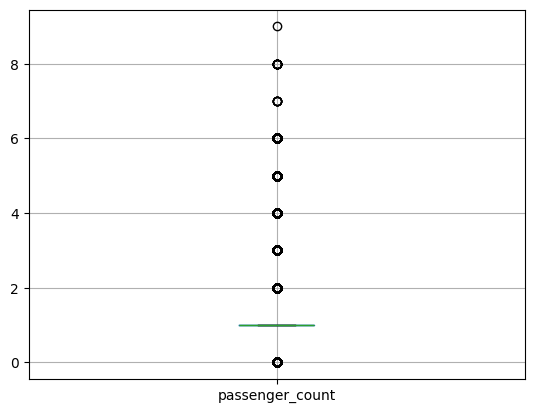

In [125]:
import matplotlib.pyplot as plt

df1.boxplot(column=["passenger_count"])

In [127]:
df1_new.isnull().sum()

pickup_datetime        0
dropoff_datetime       0
pickup_location_id     0
dropoff_location_id    0
trip_distance          0
fare_amount            0
tip_amount             0
payment_type           0
passenger_count        0
dtype: int64

In [71]:
#!pip install matplotlib

In [128]:
def filter_nyc_taxi_data(rides: pd.DataFrame, year: int, month: int) -> pd.DataFrame:
    """
    Filters NYC Taxi ride data for a specific year and month, removing outliers and invalid records.
    Applies type conversions and retains only specified columns.

    Args:
        rides (pd.DataFrame): DataFrame containing NYC Taxi ride data.
        year (int): Year to filter for.
        month (int): Month to filter for (1-12).

    Returns:
        pd.DataFrame: Filtered DataFrame containing only valid rides for the specified year and month.

    Raises:
        ValueError: If no valid rides are found or if input parameters are invalid.
    """
    # Define the column types for the final output.
    column_types = {
        "pickup_datetime": "datetime64[ns]",  # Athena: TIMESTAMP
        "dropoff_datetime": "datetime64[ns]",  # Athena: TIMESTAMP
        "pickup_location_id": "int32",         # Athena: INT
        "dropoff_location_id": "int32",        # Athena: INT
        "trip_distance": "float64",            # Athena: DOUBLE
        "fare_amount": "float64",              # Athena: DOUBLE
        "tip_amount": "float64",               # Athena: DOUBLE
        "payment_type": "int8",                # Athena: TINYINT
        "passenger_count": "int8",             # Athena: TINYINT
    }

    # Validate inputs.
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not isinstance(year, int) or not isinstance(month, int):
        raise ValueError("Year and month must be integers.")

    # Calculate the start and end date for the target month.
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year + (month // 12), (month % 12) + 1, 1)

    # Record the initial number of records.
    total_records = len(rides)

    # Remove rows missing critical values.
    critical_columns = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "total_amount",
        "PULocationID",
        "DOLocationID",
        "trip_distance",
        "passenger_count",
    ]
    rides_clean = rides.dropna(subset=critical_columns)
    dropped_missing = total_records - len(rides_clean)

    # Apply the date filter early so that expensive calculations run on a smaller subset.
    date_range_filter = (rides_clean["tpep_pickup_datetime"] >= start_date) & (
        rides_clean["tpep_pickup_datetime"] < end_date
    )
    dropped_date_range = len(rides_clean) - date_range_filter.sum()
    rides_clean = rides_clean[date_range_filter]

    # Calculate ride duration. Because dropna and date filtering already returned a new DataFrame,
    # we can assign directly without triggering a SettingWithCopyWarning.
    rides_clean["duration"] = rides_clean["tpep_dropoff_datetime"] - rides_clean["tpep_pickup_datetime"]

    # Instead of calculating quantiles separately for each column, compute them together.
    quantiles = rides_clean[["duration", "total_amount", "trip_distance"]].quantile(0.999)
    max_duration = quantiles["duration"]
    max_total_amount = quantiles["total_amount"]
    max_distance = quantiles["trip_distance"]

    # Define additional filtering thresholds.
    min_total_amount = 2.5
    invalid_location_ids = [1, 264, 265]
    min_passenger_count = 1
    max_passenger_count = 5

    # Create boolean masks for the various filters.
    duration_filter = (rides_clean["duration"] > pd.Timedelta(0)) & (rides_clean["duration"] <= max_duration)
    total_amount_filter = (rides_clean["total_amount"] >= min_total_amount) & (rides_clean["total_amount"] <= max_total_amount)
    distance_filter = (rides_clean["trip_distance"] > 0) & (rides_clean["trip_distance"] <= max_distance)
    nyc_location_filter = ~rides_clean["PULocationID"].isin(invalid_location_ids)
    passenger_count_filter = (rides_clean["passenger_count"] >= min_passenger_count) & (
        rides_clean["passenger_count"] <= max_passenger_count
    )

    # Log how many records each filter would drop.
    dropped_duration = len(rides_clean) - duration_filter.sum()
    dropped_total_amount = len(rides_clean) - total_amount_filter.sum()
    dropped_distance = len(rides_clean) - distance_filter.sum()
    dropped_location = len(rides_clean) - nyc_location_filter.sum()
    dropped_passenger_count = len(rides_clean) - passenger_count_filter.sum()

    # Combine all filters into a final mask.
    final_filter = (
        duration_filter
        & total_amount_filter
        & distance_filter
        & nyc_location_filter
        & passenger_count_filter
    )
    filtered_rides = rides_clean[final_filter].copy()

    if filtered_rides.empty:
        raise ValueError("No valid rides found after applying filters.")

    # Rename columns and perform type conversions in one chain.
    filtered_rides = (
        filtered_rides.rename(
            columns={
                "tpep_pickup_datetime": "pickup_datetime",
                "tpep_dropoff_datetime": "dropoff_datetime",
                "PULocationID": "pickup_location_id",
                "DOLocationID": "dropoff_location_id",
            }
        )[list(column_types.keys())]
        .astype(column_types)
    )

    valid_records = len(filtered_rides)
    records_dropped = total_records - valid_records
    percent_dropped = (records_dropped / total_records) * 100

    # Combine all logging information into one output string.
    stats_msg = (
        f"Total records: {total_records:,}\n"
        f"Valid records: {valid_records:,}\n"
        f"Records dropped: {records_dropped:,} ({percent_dropped:.2f}%)\n"
        f"Records dropped due to missing values: {dropped_missing:,}\n"
        f"Records dropped by date range filter: {dropped_date_range:,}\n"
        f"Records dropped by duration filter: {dropped_duration:,}\n"
        f"Records dropped by total amount filter: {dropped_total_amount:,}\n"
        f"Records dropped by distance filter: {dropped_distance:,}\n"
        f"Records dropped by NYC location filter: {dropped_location:,}\n"
        f"Records dropped by passenger count filter: {dropped_passenger_count:,}"
    )
    print(stats_msg)

    return filtered_rides

In [129]:
filter_nyc_taxi_data(df2, 2023, 2)

Total records: 2,913,955
Valid records: 2,667,594
Records dropped: 246,361 (8.45%)
Records dropped due to missing values: 76,817
Records dropped by date range filter: 55
Records dropped by duration filter: 3,824
Records dropped by total amount filter: 28,549
Records dropped by distance filter: 39,183
Records dropped by NYC location filter: 36,431
Records dropped by passenger count filter: 74,078


,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,fare_amount,tip_amount,payment_type,passenger_count
0,2023-02-01 00:32:53,2023-02-01 00:34:34,142,163,0.30,4.4,0.00,2,2
4,2023-02-01 00:12:28,2023-02-01 00:25:46,161,145,3.22,17.0,3.30,1,1
5,2023-02-01 00:52:40,2023-02-01 01:07:18,148,236,5.10,21.9,5.35,1,1
6,2023-02-01 00:12:39,2023-02-01 00:40:36,137,244,8.90,41.5,3.50,1,1
7,2023-02-01 00:56:53,2023-02-01 01:00:37,263,141,1.20,7.2,2.44,1,1
...,...,...,...,...,...,...,...,...,...
2837133,2023-02-28 23:47:42,2023-02-28 23:54:17,239,50,1.76,10.0,3.00,1,1
2837134,2023-02-28 23:10:57,2023-02-28 23:17:52,50,239,1.86,10.7,3.14,1,2
2837135,2023-02-28 23:09:54,2023-02-28 23:23:41,142,234,2.75,16.3,4.26,1,1
2837136,2023-02-28 23:50:17,2023-03-01 00:14:33,186,7,8.36,37.3,0.00,1,1


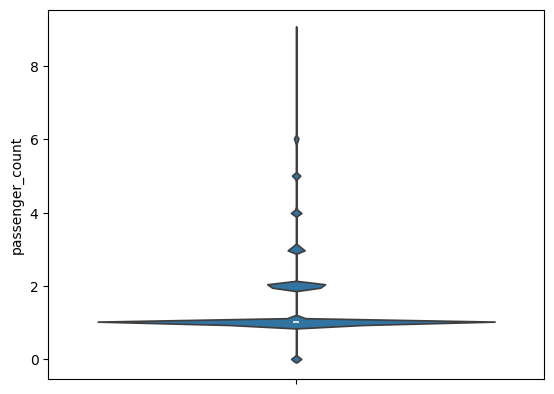

In [130]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(y=df1['passenger_count'])
plt.show()


In [151]:
import boto3
import pandas as pd
from io import BytesIO

def filter_nyc_taxi_data(year: int, month: int, bucket_name: str, s3_key_prefix: str) -> str:
    """
    Filters NYC Taxi ride data for a specific year and month, removing outliers and invalid records.
    Applies type conversions and retains only specified columns.

    Args:
        year (int): Year to filter for.
        month (int): Month to filter for (1-12).
        bucket_name (str): Name of the S3 bucket.
        s3_key_prefix (str): Prefix for the S3 key.
        local_save_path (str): Local path to save the filtered DataFrame.

    Returns:
        str: Message indicating the success of the operation.

    Raises:
        ValueError: If no valid rides are found or if input parameters are invalid.
    """
    # Define the column types for the final output.
    column_types = {
        "pickup_datetime": "datetime64[ns]",
        "dropoff_datetime": "datetime64[ns]",
        "pickup_location_id": "int32",
        "dropoff_location_id": "int32",
        "trip_distance": "float64",
        "fare_amount": "float64",
        "tip_amount": "float64",
        "payment_type": "int32",
        "passenger_count": "int32",
    }

    # Validate inputs.
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not isinstance(year, int) or not isinstance(month, int):
        raise ValueError("Year and month must be integers.")

    s3_key = f"{s3_key_prefix}/year={year}/month={month:02}/yellow_tripdata_{year}-{month:02}.parquet"

    # Initialize the S3 client
    s3 = boto3.client('s3')

    # Fetch the Parquet file from S3
    try:
        response = s3.get_object(Bucket=bucket_name, Key=s3_key)
        # Read the content of the Parquet file into a Pandas DataFrame
        data = response['Body'].read()
        rides = pd.read_parquet(BytesIO(data))
        print("Parquet file successfully read into a DataFrame!")
    except Exception as e:
        print(f"Error fetching or reading the Parquet file: {e}")
        return f"Error: {e}"

    # Calculate the start and end date for the target month.
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year + (month // 12), (month % 12) + 1, 1)

    # Record the initial number of records.
    total_records = len(rides)

    # Remove rows missing critical values.
    critical_columns = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "total_amount",
        "PULocationID",
        "DOLocationID",
        "trip_distance",
        "passenger_count",
    ]
    rides_clean = rides.dropna(subset=critical_columns)
    dropped_missing = total_records - len(rides_clean)

    # Apply the date filter early so that expensive calculations run on a smaller subset.
    date_range_filter = (rides_clean["tpep_pickup_datetime"] >= start_date) & (
        rides_clean["tpep_pickup_datetime"] < end_date
    )
    dropped_date_range = len(rides_clean) - date_range_filter.sum()
    rides_clean = rides_clean[date_range_filter]

    # Calculate ride duration. Because dropna and date filtering already returned a new DataFrame,
    # we can assign directly without triggering a SettingWithCopyWarning.
    rides_clean["duration"] = rides_clean["tpep_dropoff_datetime"] - rides_clean["tpep_pickup_datetime"]

    # Instead of calculating quantiles separately for each column, compute them together.
    quantiles = rides_clean[["duration", "total_amount", "trip_distance"]].quantile(0.999)
    max_duration = quantiles["duration"]
    max_total_amount = quantiles["total_amount"]
    max_distance = quantiles["trip_distance"]

    # Define additional filtering thresholds.
    min_total_amount = 2.5
    invalid_location_ids = [1, 264, 265]
    min_passenger_count = 1
    max_passenger_count = 5

    # Create boolean masks for the various filters.
    duration_filter = (rides_clean["duration"] > pd.Timedelta(0)) & (rides_clean["duration"] <= max_duration)
    total_amount_filter = (rides_clean["total_amount"] >= min_total_amount) & (rides_clean["total_amount"] <= max_total_amount)
    distance_filter = (rides_clean["trip_distance"] > 0) & (rides_clean["trip_distance"] <= max_distance)
    nyc_location_filter = ~rides_clean["PULocationID"].isin(invalid_location_ids)
    passenger_count_filter = (rides_clean["passenger_count"] >= min_passenger_count) & (
        rides_clean["passenger_count"] <= max_passenger_count
    )

    # Combine all filters into a final mask.
    final_filter = (
        duration_filter
        & total_amount_filter
        & distance_filter
        & nyc_location_filter
        & passenger_count_filter
    )
    filtered_rides = rides_clean[final_filter].copy()

    if filtered_rides.empty:
        raise ValueError("No valid rides found after applying filters.")

    # Rename columns and perform type conversions in one chain.
    filtered_rides = (
        filtered_rides.rename(
            columns={
                "tpep_pickup_datetime": "pickup_datetime",
                "tpep_dropoff_datetime": "dropoff_datetime",
                "PULocationID": "pickup_location_id",
                "DOLocationID": "dropoff_location_id",
            }
        )[list(column_types.keys())]
        .astype(column_types)
    )

    # Log how many records each filter would drop.
    dropped_duration = len(rides_clean) - duration_filter.sum()
    dropped_total_amount = len(rides_clean) - total_amount_filter.sum()
    dropped_distance = len(rides_clean) - distance_filter.sum()
    dropped_location = len(rides_clean) - nyc_location_filter.sum()
    dropped_passenger_count = len(rides_clean) - passenger_count_filter.sum()

    valid_records = len(filtered_rides)
    records_dropped = total_records - valid_records
    percent_dropped = (records_dropped / total_records) * 100

    # Combine all logging information into one output string.
    stats_msg = (
        f"Total records: {total_records:,}\n"
        f"Valid records: {valid_records:,}\n"
        f"Records dropped: {records_dropped:,} ({percent_dropped:.2f}%)\n"
        f"Records dropped due to missing values: {dropped_missing:,}\n"
        f"Records dropped by date range filter: {dropped_date_range:,}\n"
        f"Records dropped by duration filter: {dropped_duration:,}\n"
        f"Records dropped by total amount filter: {dropped_total_amount:,}\n"
        f"Records dropped by distance filter: {dropped_distance:,}\n"
        f"Records dropped by NYC location filter: {dropped_location:,}\n"
        f"Records dropped by passenger count filter: {dropped_passenger_count:,}"
    )
    print(stats_msg)

    # Save the DataFrame locally as a Parquet file.
    local_file_path = f"yellow_tripdata_{year}-{month:02}.parquet"
    filtered_rides.to_parquet(local_file_path, index=False)
    print(f"Filtered DataFrame saved locally at {local_file_path}")

    # Save the DataFrame to a Parquet file in memory for S3 upload.
    buffer = BytesIO()
    filtered_rides.to_parquet(buffer, index=False)
    buffer.seek(0)

    # Define the S3 key for the filtered data.
    s3_key = f"{s3_key_prefix.replace('raw', 'filtered')}/year={year}/month={month:02}/yellow_tripdata_{year}-{month:02}.parquet"

    # Upload the Parquet file to S3.
    try:
        s3.upload_fileobj(buffer, bucket_name, s3_key)
        print(f"File successfully uploaded to s3://{bucket_name}/{s3_key}")
    except Exception as e:
        print(f"Error uploading file to S3: {e}")
        return f"Error: {e}"

    return f"Filtered data saved locally and uploaded to S3 successfully."

In [152]:
bucket_name = "mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990"
s3_key_prefix = "taxi/raw"
df = filter_nyc_taxi_data(2023, 1, bucket_name, s3_key_prefix)

Parquet file successfully read into a DataFrame!
Total records: 3,066,766
Valid records: 2,812,155
Records dropped: 254,611 (8.30%)
Records dropped due to missing values: 71,743
Records dropped by date range filter: 48
Records dropped by duration filter: 4,096
Records dropped by total amount filter: 29,078
Records dropped by distance filter: 41,356
Records dropped by NYC location filter: 41,825
Records dropped by passenger count filter: 79,308
Filtered DataFrame saved locally at yellow_tripdata_2023-01.parquet
File successfully uploaded to s3://mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990/taxi/filtered/year=2023/month=01/yellow_tripdata_2023-01.parquet


In [ ]:
import sys

from awsglue.context import GlueContext
from awsglue.job import Job
from awsglue.utils import getResolvedOptions
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, lit, to_timestamp, unix_timestamp

# Get job arguments
args = getResolvedOptions(
    sys.argv, ["JOB_NAME", "year", "month", "bucket_name", "s3_key_prefix"]
)

# Initialize Glue context and Spark session
spark = SparkSession.builder.appName("ClassFilterNYCTaxiData").getOrCreate()
glueContext = GlueContext(spark)
job = Job(glueContext)
job.init(args["JOB_NAME"], args)

# Read arguments
year = int(args["year"])
month = int(args["month"])
bucket_name = args["bucket_name"]
s3_key_prefix = args["s3_key_prefix"]

# Define S3 paths
input_s3_key = f"s3://{bucket_name}/{s3_key_prefix}/year={year}/month={month:02}/yellow_tripdata_{year}-{month:02}.parquet"
output_s3_key = f"s3://{bucket_name}/{s3_key_prefix.replace('raw', 'glue-filtered')}/year={year}/month={month:02}/yellow_tripdata_{year}-{month:02}.parquet"

# Read the Parquet file into a Spark DataFrame
rides = spark.read.parquet(input_s3_key)

# Total records before any filtering
total_records = rides.count()

# Define the start and end date for filtering
start_date = f"{year}-{month:02}-01"
end_date = f"{year + (month // 12)}-{(month % 12) + 1:02}-01"

# Filter and clean the data
rides_clean = rides.filter(
    (col("tpep_pickup_datetime").isNotNull())
    & (col("tpep_dropoff_datetime").isNotNull())
    & (col("total_amount").isNotNull())
    & (col("PULocationID").isNotNull())
    & (col("DOLocationID").isNotNull())
    & (col("trip_distance").isNotNull())
    & (col("passenger_count").isNotNull())
)

# Records dropped due to missing values
dropped_missing = total_records - rides_clean.count()

rides_clean = rides_clean.filter(
    (col("tpep_pickup_datetime") >= start_date)
    & (col("tpep_pickup_datetime") < end_date)
)

# Records dropped by date range filter
dropped_date_range = total_records - dropped_missing - rides_clean.count()

# Convert duration to seconds for compatibility with approxQuantile
rides_clean = rides_clean.withColumn(
    "duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")),
)

# Calculate quantiles for filtering
quantiles = rides_clean.approxQuantile(
    ["duration", "total_amount", "trip_distance"], [0.999], 0.01
)
max_duration, max_total_amount, max_distance = (
    quantiles[0][0],
    quantiles[1][0],
    quantiles[2][0],
)

# Apply additional filters
rides_filtered = rides_clean.filter(
    (col("duration") > lit(0)) & (col("duration") <= lit(max_duration))
)
dropped_duration = rides_clean.count() - rides_filtered.count()

rides_filtered = rides_filtered.filter(
    (col("total_amount") >= lit(2.5)) & (col("total_amount") <= lit(max_total_amount))
)
dropped_total_amount = rides_clean.count() - rides_filtered.count()

rides_filtered = rides_filtered.filter(
    (col("trip_distance") > lit(0)) & (col("trip_distance") <= lit(max_distance))
)
dropped_distance = rides_clean.count() - rides_filtered.count()

rides_filtered = rides_filtered.filter(~col("PULocationID").isin([1, 264, 265]))
dropped_location = rides_clean.count() - rides_filtered.count()

rides_filtered = rides_filtered.filter(
    (col("passenger_count") >= lit(1)) & (col("passenger_count") <= lit(5))
)
dropped_passenger_count = rides_clean.count() - rides_filtered.count()

# Final record count
valid_records = rides_filtered.count()
records_dropped = total_records - valid_records
percent_dropped = (records_dropped / total_records) * 100

# Combine all logging information into one output string
stats_msg = (
    f"Total records: {total_records:,}\n"
    f"Valid records: {valid_records:,}\n"
    f"Records dropped: {records_dropped:,} ({percent_dropped:.2f}%)\n"
    f"Records dropped due to missing values: {dropped_missing:,}\n"
    f"Records dropped by date range filter: {dropped_date_range:,}\n"
    f"Records dropped by duration filter: {dropped_duration:,}\n"
    f"Records dropped by total amount filter: {dropped_total_amount:,}\n"
    f"Records dropped by distance filter: {dropped_distance:,}\n"
    f"Records dropped by NYC location filter: {dropped_location:,}\n"
    f"Records dropped by passenger count filter: {dropped_passenger_count:,}"
)
print(stats_msg)

# Rename columns and cast to the required data types
rides_final = (
    rides_filtered.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime")
    .withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")
    .withColumnRenamed("PULocationID", "pickup_location_id")
    .withColumnRenamed("DOLocationID", "dropoff_location_id")
    .select(
        col("pickup_datetime").cast("timestamp"),
        col("dropoff_datetime").cast("timestamp"),
        col("pickup_location_id").cast("int"),
        col("dropoff_location_id").cast("int"),
        col("trip_distance").cast("double"),
        col("fare_amount").cast("double"),
        col("tip_amount").cast("double"),
        col("payment_type").cast("int"),
        col("passenger_count").cast("int"),
    )
)

# Write the filtered data back to S3
rides_final.write.mode("overwrite").parquet(output_s3_key)

print(f"Filtered data written to {output_s3_key}")

# Commit the job
job.commit()

In [143]:
import boto3
import pandas as pd
import s3fs
# S3 bucket and prefix
bucket_name = "mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990"
prefix = "taxi/glue-filtered/year=2023/month=01/yellow_tripdata_2023-01.parquet/"

# Initialize S3 client
s3 = boto3.client("s3")

# List all Parquet files in the S3 directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
parquet_files = [f"s3://{bucket_name}/{obj['Key']}" for obj in response.get("Contents", []) if obj["Key"].endswith(".parquet")]

# Read all Parquet files and combine them into a single Pandas DataFrame
df = pd.concat([pd.read_parquet(file, storage_options={"anon": False}) for file in parquet_files], ignore_index=True)

# Display the combined DataFrame
print(df)

            pickup_datetime    dropoff_datetime  pickup_location_id  \
0       2023-01-01 00:32:10 2023-01-01 00:40:36                 161   
1       2023-01-01 00:55:08 2023-01-01 01:01:27                  43   
2       2023-01-01 00:25:04 2023-01-01 00:37:49                  48   
3       2023-01-01 00:10:29 2023-01-01 00:21:19                 107   
4       2023-01-01 00:50:34 2023-01-01 01:02:52                 161   
...                     ...                 ...                 ...   
2818345 2023-01-31 23:00:19 2023-02-01 00:08:33                 228   
2818346 2023-01-31 23:14:38 2023-01-31 23:25:30                 263   
2818347 2023-01-31 23:44:51 2023-01-31 23:58:45                  79   
2818348 2023-01-31 23:45:00 2023-01-31 23:55:46                  68   
2818349 2023-01-31 23:22:47 2023-01-31 23:26:24                 236   

         dropoff_location_id  trip_distance  fare_amount  tip_amount  \
0                        141           0.97          9.3        0.00   
1  

In [145]:
df

,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,fare_amount,tip_amount,payment_type,passenger_count,year,month
0,2023-01-01 00:32:10,2023-01-01 00:40:36,161,141,0.97,9.3,0.00,2,1,2023,1
1,2023-01-01 00:55:08,2023-01-01 01:01:27,43,237,1.10,7.9,4.00,1,1,2023,1
2,2023-01-01 00:25:04,2023-01-01 00:37:49,48,238,2.51,14.9,15.00,1,1,2023,1
3,2023-01-01 00:10:29,2023-01-01 00:21:19,107,79,1.43,11.4,3.28,1,1,2023,1
4,2023-01-01 00:50:34,2023-01-01 01:02:52,161,137,1.84,12.8,10.00,1,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...
2818345,2023-01-31 23:00:19,2023-02-01 00:08:33,228,159,13.90,50.5,0.00,1,1,2023,1
2818346,2023-01-31 23:14:38,2023-01-31 23:25:30,263,107,3.37,15.6,2.00,1,1,2023,1
2818347,2023-01-31 23:44:51,2023-01-31 23:58:45,79,246,2.86,16.3,2.00,1,1,2023,1
2818348,2023-01-31 23:45:00,2023-01-31 23:55:46,68,238,3.80,17.7,2.50,1,2,2023,1


In [146]:
import pandas as pd

# Define the S3 file path
s3_file_path = "s3://mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990/taxi/glue-filtered/year=2023/month=01/yellow_tripdata_2023-01.parquet/part-00005-ce4e03c6-175a-4b5b-80ac-f08db956228e-c000.snappy.parquet"

# Read the Parquet file into a Pandas DataFrame
df_man = pd.read_parquet(s3_file_path, storage_options={"anon": False})

# Display the first few rows of the DataFrame
df_man

,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,fare_amount,tip_amount,payment_type,passenger_count,year,month
0,2023-01-01 00:32:10,2023-01-01 00:40:36,161,141,0.97,9.3,0.00,2,1,2023,1
1,2023-01-01 00:55:08,2023-01-01 01:01:27,43,237,1.10,7.9,4.00,1,1,2023,1
2,2023-01-01 00:25:04,2023-01-01 00:37:49,48,238,2.51,14.9,15.00,1,1,2023,1
3,2023-01-01 00:10:29,2023-01-01 00:21:19,107,79,1.43,11.4,3.28,1,1,2023,1
4,2023-01-01 00:50:34,2023-01-01 01:02:52,161,137,1.84,12.8,10.00,1,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...
2818345,2023-01-31 23:00:19,2023-02-01 00:08:33,228,159,13.90,50.5,0.00,1,1,2023,1
2818346,2023-01-31 23:14:38,2023-01-31 23:25:30,263,107,3.37,15.6,2.00,1,1,2023,1
2818347,2023-01-31 23:44:51,2023-01-31 23:58:45,79,246,2.86,16.3,2.00,1,1,2023,1
2818348,2023-01-31 23:45:00,2023-01-31 23:55:46,68,238,3.80,17.7,2.50,1,2,2023,1


In [153]:
import pandas as pd

# Define the S3 file path
s3_file_path = "s3://mlops-13afe8ab-a794-4f8f-80b6-e210e18b4990/taxi/filtered/year=2023/month=01/yellow_tripdata_2023-01.parquet"

# Read the Parquet file into a Pandas DataFrame
df2 = pd.read_parquet(s3_file_path, storage_options={"anon": False})

# Display the first few rows of the DataFrame
df2

,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,trip_distance,fare_amount,tip_amount,payment_type,passenger_count,year,month
0,2023-01-01 00:32:10,2023-01-01 00:40:36,161,141,0.97,9.3,0.00,2,1,2023,1
1,2023-01-01 00:55:08,2023-01-01 01:01:27,43,237,1.10,7.9,4.00,1,1,2023,1
2,2023-01-01 00:25:04,2023-01-01 00:37:49,48,238,2.51,14.9,15.00,1,1,2023,1
3,2023-01-01 00:10:29,2023-01-01 00:21:19,107,79,1.43,11.4,3.28,1,1,2023,1
4,2023-01-01 00:50:34,2023-01-01 01:02:52,161,137,1.84,12.8,10.00,1,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...
2812150,2023-01-31 23:00:19,2023-02-01 00:08:33,228,159,13.90,50.5,0.00,1,1,2023,1
2812151,2023-01-31 23:14:38,2023-01-31 23:25:30,263,107,3.37,15.6,2.00,1,1,2023,1
2812152,2023-01-31 23:44:51,2023-01-31 23:58:45,79,246,2.86,16.3,2.00,1,1,2023,1
2812153,2023-01-31 23:45:00,2023-01-31 23:55:46,68,238,3.80,17.7,2.50,1,2,2023,1


In [154]:
df2.shape[0] - df_man.shape[0]

-6195